In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

In [156]:
seed = 22

In [157]:
df = pd.read_csv('./data/preprocessed_data.csv')

<Axes: xlabel='fire'>

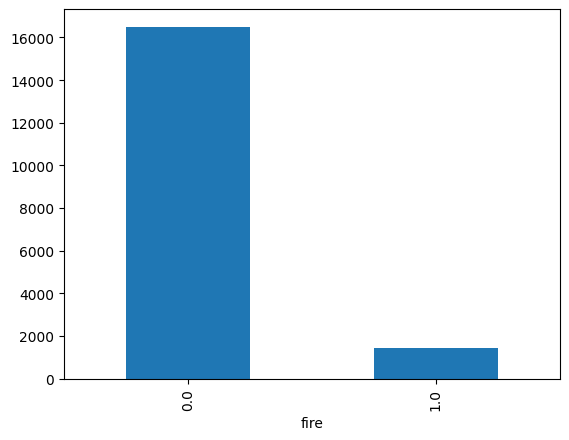

In [158]:
# 불이 안난 경우가 훨씬 많음
df['fire'].value_counts().plot.bar()

# 1. Random Undersampling

In [159]:
# 랜덤 언더샘플링으로 화재 발생하지 않은 지역 샘플링
shuffled_df = df.sample(frac=1, random_state=seed)

fire_df = shuffled_df.loc[shuffled_df['fire'] != 0]
non_fire_df = shuffled_df.loc[shuffled_df['fire'] == 0][:len(fire_df)]

norm_df = pd.concat([fire_df, non_fire_df])
rand_sub_df = norm_df.sample(frac=1, random_state=seed)

rand_sub_df.head()

,month,x,y,pop_rate,old_pop_rate,sto_num,barn_spwn_num,avg_temp,min_temp,max_temp,avg_hum,daily_pre,avg_wind,field_fire,green_fire,fire
1850,2,0.642857,0.714286,0.974965,0.732883,0.000000,0.0,0.365285,0.432507,0.320388,0.900735,0.195187,0.212121,0.571429,0.571429,1.0
4283,8,0.571429,0.285714,0.037543,0.091538,0.018868,0.0,0.898964,0.961433,0.798544,0.612132,0.000000,0.454545,0.142857,0.142857,0.0
10232,4,0.357143,0.285714,0.021799,0.048211,0.056604,0.0,0.536269,0.537190,0.541262,0.619485,0.000000,0.212121,0.000000,0.000000,0.0
10272,4,0.571429,0.642857,0.341915,0.417507,0.358491,0.0,0.536269,0.537190,0.541262,0.619485,0.000000,0.212121,0.571429,0.571429,1.0
10485,6,0.142857,0.642857,0.017771,0.037122,0.056604,0.0,0.753886,0.707989,0.813107,0.347426,0.000000,0.333333,0.285714,0.285714,1.0


<Axes: xlabel='fire'>

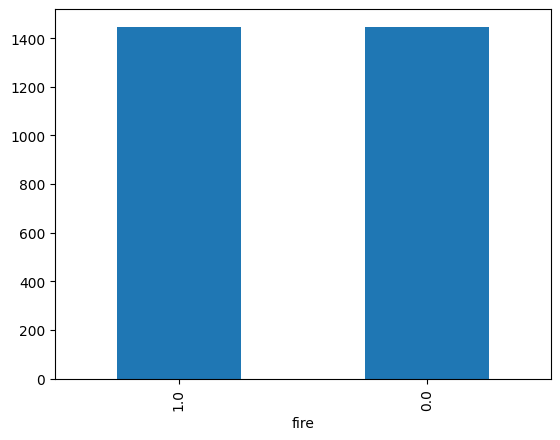

In [160]:
# 불이 난 경우와 안난 경우가 같아짐
rand_sub_df['fire'].value_counts().plot.bar()

<Axes: >

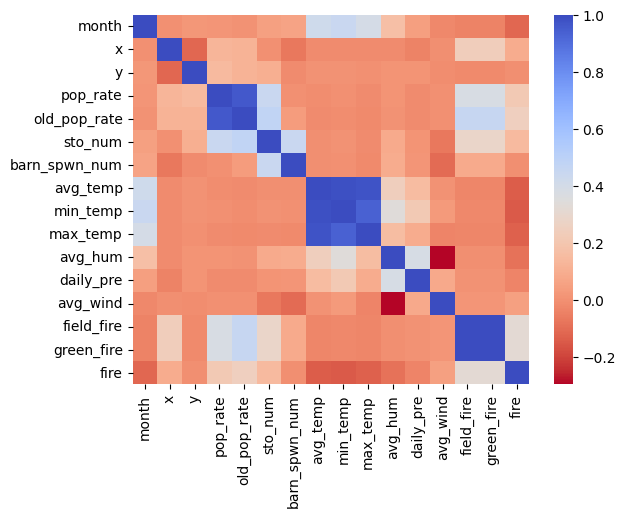

In [161]:
# 변수별 상관관계 분석
corr_under = rand_sub_df.corr()
sns.heatmap(corr, cmap='coolwarm_r')

In [162]:
# 변수별 상관관계 조사
corr_under['fire'].sort_values(ascending=False)

fire             1.000000
field_fire       0.318735
green_fire       0.318735
old_pop_rate     0.250612
pop_rate         0.214544
sto_num          0.148041
x                0.092901
avg_wind         0.051442
y               -0.003691
barn_spwn_num   -0.005124
daily_pre       -0.035464
avg_hum         -0.085533
month           -0.116969
max_temp        -0.133586
avg_temp        -0.141111
min_temp        -0.145090
Name: fire, dtype: float64

In [163]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE

from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, f1_score, average_precision_score

In [164]:
# train, test 데이터 스플릿
X = rand_sub_df.drop('fire', axis=1)
y = rand_sub_df['fire']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [165]:
# 모델 기본 파라미터로 학습
classifiers = {
    "로지스틱회귀": LogisticRegression(),
    "K최근접": KNeighborsClassifier(),
    "결정트리": DecisionTreeClassifier(),
    "랜덤포레스트": RandomForestClassifier(),
    "그라디언트부스팅": GradientBoostingClassifier()
}

for _, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print(classifier.__class__.__name__, "에서 학습 정확도", training_score.mean() * 100, "%")

LogisticRegression 에서 학습 정확도 65.96112311015119 %
KNeighborsClassifier 에서 학습 정확도 62.20302375809935 %
DecisionTreeClassifier 에서 학습 정확도 58.44492440604752 %
RandomForestClassifier 에서 학습 정확도 64.36285097192224 %
GradientBoostingClassifier 에서 학습 정확도 66.60907127429805 %


In [166]:
# 로지스틱회귀 하이퍼파라미터 튜닝
lr_params_under = {'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

lr_grid_under = GridSearchCV(LogisticRegression(), lr_params_under)
lr_grid_under.fit(X_train, y_train)
lr_best_under = lr_grid_under.best_estimator_

print('최고예측정확도: {:.2f}%'.format(lr_grid_under.best_score_ * 100), '파라미터:', lr_grid_under.best_params_)

최고예측정확도: 66.39% 파라미터: {'C': 0.1, 'penalty': 'l2'}


In [167]:
# K최근접 하이퍼파라미터 튜닝
kn_params_under = {"n_neighbors": [2, 3, 4, 5], 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

kn_grid_under = GridSearchCV(KNeighborsClassifier(), kn_params_under)
kn_grid_under.fit(X_train, y_train)
kn_best_under = kn_grid_under.best_estimator_

print('최고예측정확도: {:.2f}%'.format(kn_grid_under.best_score_ * 100), '파라미터:', kn_grid_under.best_params_)

최고예측정확도: 62.20% 파라미터: {'algorithm': 'auto', 'n_neighbors': 5}


In [168]:
# 결정트리 하이퍼파라미터 튜닝
dt_params_under = {"criterion": ["gini", "entropy"], "max_depth": [2, 3, 4, 5], "min_samples_leaf": [5, 6, 7, 8, 9]}

dt_grid_under = GridSearchCV(DecisionTreeClassifier(), dt_params_under)
dt_grid_under.fit(X_train, y_train)
dt_best_under = dt_grid_under.best_estimator_

print('최고예측정확도: {:.2f}%'.format(dt_grid_under.best_score_ * 100), '파라미터:', dt_grid_under.best_params_)

최고예측정확도: 65.44% 파라미터: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 5}


In [169]:
# 랜덤포레스트 하이퍼파라미터 튜닝
rf_params_under = { 'n_estimators' : [100], 'max_depth' : [4, 6, 8], 'min_samples_leaf' : [8, 12, 18, 20], 'min_samples_split' : [6, 8, 16]}

rf_grid_under = GridSearchCV(RandomForestClassifier(), rf_params_under)
rf_grid_under.fit(X_train, y_train)
rf_best_under = rf_grid_under.best_estimator_

print('최고예측정확도: {:.2f}%'.format(rf_grid_under.best_score_ * 100), '파라미터:', rf_grid_under.best_params_)

최고예측정확도: 67.47% 파라미터: {'max_depth': 4, 'min_samples_leaf': 8, 'min_samples_split': 16, 'n_estimators': 100}


In [170]:
# 그라디언트부스팅 하이퍼파라미터 튜닝
gb_params_under = {'max_depth':range(5,16,2), 'min_samples_split':range(200,1001,200)}

gb_grid_under = GridSearchCV(GradientBoostingClassifier(learning_rate=0.1, n_estimators=60, max_features='sqrt', subsample=0.8, random_state=10), gb_params_under)
gb_grid_under.fit(X_train, y_train)
gb_best_under = gb_grid_under.best_estimator_

print('최고예측정확도: {:.2f}%'.format(gb_grid_under.best_score_ * 100), '파라미터:', gb_grid_under.best_params_)

최고예측정확도: 67.69% 파라미터: {'max_depth': 13, 'min_samples_split': 800}


In [171]:
# 모델 알고리즘 f1 스코어 cross validation
lr_score_f1_under = cross_val_score(lr_best_under, X_train, y_train, scoring='f1', cv=5).mean()
kn_score_f1_under = cross_val_score(kn_best_under, X_train, y_train, scoring='f1', cv=5).mean()
dt_score_f1_under = cross_val_score(dt_best_under, X_train, y_train, scoring='f1', cv=5).mean()
rf_score_f1_under = cross_val_score(rf_best_under, X_train, y_train, scoring='f1', cv=5).mean()
gb_score_f1_under = cross_val_score(gb_best_under, X_train, y_train, scoring='f1', cv=5).mean()

print('로지스틱 회귀 F1 스코어: {:.2f}%'.format(lr_score_f1_under * 100))
print('K최근접 F1 스코어: {:.2f}%'.format(kn_score_f1_under * 100))
print('결정트리 F1 스코어: {:.2f}%'.format(dt_score_f1_under * 100))
print('랜덤포레스트 F1 스코어: {:.2f}%'.format(rf_score_f1_under * 100))
print('그라디언트 부스팅 F1 스코어: {:.2f}%'.format(gb_score_f1_under * 100))

로지스틱 회귀 F1 스코어: 64.95%
K최근접 F1 스코어: 62.75%
결정트리 F1 스코어: 67.09%
랜덤포레스트 F1 스코어: 68.42%
그라디언트 부스팅 F1 스코어: 68.87%


In [172]:
# 모델 알고리즘 ROC AUC 스코어 cross validation
lr_pred_under = cross_val_predict(lr_best_under, X_train, y_train, cv=5, method="decision_function")
kn_pred_under = cross_val_predict(kn_best_under, X_train, y_train, cv=5)
dt_pred_under = cross_val_predict(dt_best_under, X_train, y_train, cv=5)
rf_pred_under = cross_val_predict(rf_best_under, X_train, y_train, cv=5)
gb_pred_under = cross_val_predict(gb_best_under, X_train, y_train, cv=5)

lr_score_auc_under = roc_auc_score(y_train, lr_pred_under)
kn_score_auc_under = roc_auc_score(y_train, kn_pred_under)
dt_score_auc_under = roc_auc_score(y_train, dt_pred_under)
rf_score_auc_under = roc_auc_score(y_train, rf_pred_under)
gb_score_auc_under = roc_auc_score(y_train, gb_pred_under)

print('로지스틱 회귀 ROC AUC 스코어: {:.5f}'.format(lr_score_auc_under))
print('K최근접 ROC AUC 스코어: {:.5f}'.format(kn_score_auc_under))
print('결정트리 ROC AUC 스코어: {:.5f}'.format(dt_score_auc_under))
print('랜덤포레스트 ROC AUC 스코어: {:.5f}'.format(rf_score_auc_under))
print('그라디언트 부스팅 ROC AUC 스코어: {:.5f}'.format(gb_score_auc_under))

로지스틱 회귀 ROC AUC 스코어: 0.71382
K최근접 ROC AUC 스코어: 0.62195
결정트리 ROC AUC 스코어: 0.65407
랜덤포레스트 ROC AUC 스코어: 0.66671
그라디언트 부스팅 ROC AUC 스코어: 0.67664


In [173]:
# 테스트 정확도
lr_test_pred_under = lr_best_under.predict(X_test)
kn_test_pred_under = kn_best_under.predict(X_test)
dt_test_pred_under = dt_best_under.predict(X_test)
rf_test_pred_under = rf_best_under.predict(X_test)
gb_test_pred_under = gb_best_under.predict(X_test)

lr_score_acc_under = accuracy_score(y_test, lr_test_pred_under)
kn_score_acc_under = accuracy_score(y_test, kn_test_pred_under)
dt_score_acc_under = accuracy_score(y_test, dt_test_pred_under)
rf_score_acc_under = accuracy_score(y_test, rf_test_pred_under)
gb_score_acc_under = accuracy_score(y_test, gb_test_pred_under)

print('테스트 로지스틱 회귀 정확도: {:.2f}%'.format(lr_score_acc_under * 100))
print('테스트 K최근접 정확도: {:.2f}%'.format(kn_score_acc_under * 100))
print('테스트 결정트리 정확도: {:.2f}%'.format(dt_score_acc_under * 100))
print('테스트 랜덤포레스트 정확도: {:.2f}%'.format(rf_score_acc_under * 100))
print('테스트 그라디언트 부스팅 정확도: {:.2f}%'.format(gb_score_acc_under * 100))

테스트 로지스틱 회귀 정확도: 68.39%
테스트 K최근접 정확도: 63.21%
테스트 결정트리 정확도: 67.88%
테스트 랜덤포레스트 정확도: 68.05%
테스트 그라디언트 부스팅 정확도: 68.91%


Undersampling에서는 그라디언트 부스팅이 적절해보임

# 2. SMOTE Oversampling

In [174]:
# 데이터셋 스플릿
X = df.drop('fire', axis=1)
y = df['fire']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [176]:
# SMOTE 기법으로 오버샘플링
sm = SMOTE(sampling_strategy='auto', random_state=seed)

over_X_train, over_y_train = sm.fit_resample(X_train, y_train)

<Axes: xlabel='fire'>

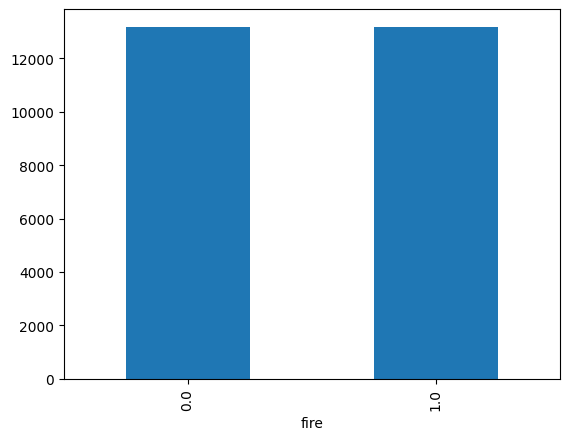

In [177]:
# 오버샘플링한 데이터 분포 확인
over_y_train.value_counts().plot.bar()

<Axes: >

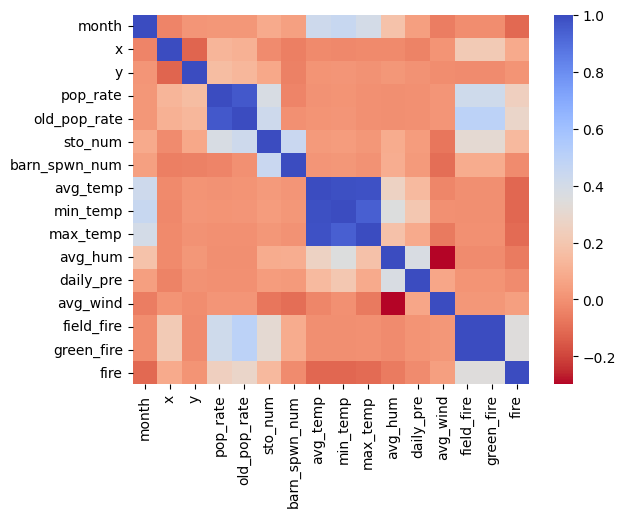

In [326]:
# 변수별 상관관계 분석
corr_df = over_X_train.copy()
corr_df['fire'] = over_y_train
corr_over = corr_df.corr()
sns.heatmap(corr_over, cmap='coolwarm_r')

In [327]:
# 변수별 상관관계 조사
corr_over['fire'].sort_values(ascending=False)

fire             1.000000
field_fire       0.344988
green_fire       0.344988
old_pop_rate     0.284540
pop_rate         0.246373
sto_num          0.138099
x                0.086236
avg_wind         0.042375
y                0.007963
daily_pre       -0.016419
barn_spwn_num   -0.018749
avg_hum         -0.062556
max_temp        -0.108573
month           -0.111803
avg_temp        -0.116140
min_temp        -0.120622
Name: fire, dtype: float64

In [178]:
# 모델 기본 파라미터로 학습
classifiers = {
    "로지스틱회귀": LogisticRegression(),
    "K최근접": KNeighborsClassifier(),
    "결정트리": DecisionTreeClassifier(),
    "랜덤포레스트": RandomForestClassifier(),
    "그라디언트 부스팅": GradientBoostingClassifier()
}

for _, classifier in classifiers.items():
    classifier.fit(over_X_train, over_y_train)
    training_score = cross_val_score(classifier, over_X_train, over_y_train, cv=5)
    print(classifier.__class__.__name__, "에서 학습 정확도", round(training_score.mean(), 2) * 100, "%")

LogisticRegression 에서 학습 정확도 68.0 %
KNeighborsClassifier 에서 학습 정확도 86.0 %
DecisionTreeClassifier 에서 학습 정확도 90.0 %
RandomForestClassifier 에서 학습 정확도 95.0 %
GradientBoostingClassifier 에서 학습 정확도 91.0 %


In [179]:
# 로지스틱회귀 하이퍼파라미터 튜닝
lr_params_over = {'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

lr_grid_over = GridSearchCV(LogisticRegression(), lr_params_over)
lr_grid_over.fit(over_X_train, over_y_train)
lr_best_over = lr_grid_over.best_estimator_

print('최고예측정확도: {:.2f}%'.format(lr_grid_over.best_score_ * 100), '파라미터:', lr_grid_over.best_params_)

최고예측정확도: 67.83% 파라미터: {'C': 0.01, 'penalty': 'l2'}


In [180]:
# K최근접 하이퍼파라미터 튜닝
kn_params_over = {"n_neighbors": [2, 3, 4], 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

kn_grid_over = GridSearchCV(KNeighborsClassifier(), kn_params_over)
kn_grid_over.fit(over_X_train, over_y_train)
kn_best_over = kn_grid_over.best_estimator_

print('최고예측정확도: {:.2f}%'.format(kn_grid_over.best_score_ * 100), '파라미터:', kn_grid_over.best_params_)

최고예측정확도: 92.03% 파라미터: {'algorithm': 'auto', 'n_neighbors': 2}


In [181]:
# 결정트리 하이퍼파라미터 튜닝
dt_params_over = {"criterion": ["gini", "entropy"], "max_depth": [None], "min_samples_leaf": [1, 5, 6, 7, 8, 9]}

dt_grid_over = GridSearchCV(DecisionTreeClassifier(), dt_params_over)
dt_grid_over.fit(over_X_train, over_y_train)
dt_best_over = dt_grid_over.best_estimator_

print('최고예측정확도: {:.2f}%'.format(dt_grid_over.best_score_ * 100), '파라미터:', dt_grid_over.best_params_)

최고예측정확도: 90.74% 파라미터: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1}


In [182]:
# 랜덤포레스트 하이퍼파라미터 튜닝
rf_params_over = { 'n_estimators' : [100], 'max_depth' : [None], 'min_samples_leaf' : [1, 8, 12, 18, 20], 'min_samples_split' : [2, 6, 8, 16]}

rf_grid_over = GridSearchCV(RandomForestClassifier(), rf_params_over)
rf_grid_over.fit(over_X_train, over_y_train)
rf_best_over = rf_grid_over.best_estimator_

print('최고예측정확도: {:.2f}%'.format(rf_grid_over.best_score_ * 100), '파라미터:', rf_grid_over.best_params_)

최고예측정확도: 95.05% 파라미터: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [183]:
# 그라디언트부스팅 하이퍼파라미터 튜닝
gb_params_over = {'max_depth':range(5,16,2), 'min_samples_split':range(200,1001,200)}

gb_grid_over = GridSearchCV(GradientBoostingClassifier(learning_rate=0.1, n_estimators=60, max_features='sqrt', subsample=0.8, random_state=10), gb_params_over)
gb_grid_over.fit(over_X_train, over_y_train)
gb_best_over = gb_grid_over.best_estimator_

print('최고예측정확도: {:.2f}%'.format(gb_grid_over.best_score_ * 100), '파라미터:', gb_grid_over.best_params_)

최고예측정확도: 94.23% 파라미터: {'max_depth': 15, 'min_samples_split': 200}


In [184]:
# 모델 알고리즘 f1 스코어 cross validation
lr_score_f1_over = cross_val_score(lr_best_over, over_X_train, over_y_train, scoring='f1', cv=5).mean()
kn_score_f1_over = cross_val_score(kn_best_over, over_X_train, over_y_train, scoring='f1', cv=5).mean()
dt_score_f1_over = cross_val_score(dt_best_over, over_X_train, over_y_train, scoring='f1', cv=5).mean()
rf_score_f1_over = cross_val_score(rf_best_over, over_X_train, over_y_train, scoring='f1', cv=5).mean()
gb_score_f1_over = cross_val_score(gb_best_over, over_X_train, over_y_train, scoring='f1', cv=5).mean()

print('로지스틱 회귀 F1 스코어: {:.2f}%'.format(lr_score_f1_over * 100))
print('K최근접 F1 스코어: {:.2f}%'.format(kn_score_f1_over * 100))
print('결정트리 F1 스코어: {:.2f}%'.format(dt_score_f1_over * 100))
print('랜덤포레스트 F1 스코어: {:.2f}%'.format(rf_score_f1_over * 100))
print('그라디언트 부스팅 F1 스코어: {:.2f}%'.format(gb_score_f1_over * 100))

로지스틱 회귀 F1 스코어: 65.80%
K최근접 F1 스코어: 92.34%
결정트리 F1 스코어: 90.18%
랜덤포레스트 F1 스코어: 94.48%
그라디언트 부스팅 F1 스코어: 93.29%


In [185]:
# 모델 알고리즘 ROC AUC 스코어 cross validation
lr_pred_over = cross_val_predict(lr_best_over, over_X_train, over_y_train, cv=5, method="decision_function")
kn_pred_over = cross_val_predict(kn_best_over, over_X_train, over_y_train, cv=5)
dt_pred_over = cross_val_predict(dt_best_over, over_X_train, over_y_train, cv=5)
rf_pred_over = cross_val_predict(rf_best_over, over_X_train, over_y_train, cv=5)
gb_pred_over = cross_val_predict(gb_best_over, over_X_train, over_y_train, cv=5)


lr_score_auc_over = roc_auc_score(over_y_train, lr_pred_over)
kn_score_auc_over = roc_auc_score(over_y_train, kn_pred_over)
dt_score_auc_over = roc_auc_score(over_y_train, dt_pred_over)
rf_score_auc_over = roc_auc_score(over_y_train, rf_pred_over)
gb_score_auc_over = roc_auc_score(over_y_train, gb_pred_over)

print('로지스틱 회귀 ROC AUC 스코어: {:.5f}'.format(lr_score_auc_over))
print('K최근접 ROC AUC 스코어: {:.5f}'.format(kn_score_auc_over))
print('결정트리 ROC AUC 스코어: {:.5f}'.format(dt_score_auc_over))
print('랜덤포레스트 ROC AUC 스코어: {:.5f}'.format(rf_score_auc_over))
print('그라디언트 부스팅 ROC AUC 스코어: {:.5f}'.format(gb_score_auc_over))

로지스틱 회귀 ROC AUC 스코어: 0.73855
K최근접 ROC AUC 스코어: 0.92029
결정트리 ROC AUC 스코어: 0.90846
랜덤포레스트 ROC AUC 스코어: 0.95025
그라디언트 부스팅 ROC AUC 스코어: 0.94233


In [186]:
# 테스트 정확도
lr_test_pred_over = lr_best_over.predict(X_test)
kn_test_pred_over = kn_best_over.predict(X_test)
dt_test_pred_over = dt_best_over.predict(X_test)
rf_test_pred_over = rf_best_over.predict(X_test)
gb_test_pred_over = gb_best_over.predict(X_test)

lr_score_acc_over = accuracy_score(y_test, lr_test_pred_over)
kn_score_acc_over = accuracy_score(y_test, kn_test_pred_over)
dt_score_acc_over = accuracy_score(y_test, dt_test_pred_over)
rf_score_acc_over = accuracy_score(y_test, rf_test_pred_over)
gb_score_acc_over = accuracy_score(y_test, gb_test_pred_over)

print('테스트 로지스틱 회귀 정확도: {:.2f}%'.format(lr_score_acc_over * 100))
print('테스트 K최근접 정확도: {:.2f}%'.format(kn_score_acc_over * 100))
print('테스트 결정트리 정확도: {:.2f}%'.format(dt_score_acc_over * 100))
print('테스트 랜덤포레스트 정확도: {:.2f}%'.format(rf_score_acc_over * 100))
print('테스트 그라디언트 부스팅 정확도: {:.2f}%'.format(gb_score_acc_over * 100))

테스트 로지스틱 회귀 정확도: 70.98%
테스트 K최근접 정확도: 84.13%
테스트 결정트리 정확도: 83.57%
테스트 랜덤포레스트 정확도: 90.42%
테스트 그라디언트 부스팅 정확도: 89.97%


Oversampling의 경우 랜덤포레스트 모델이 가장 성능이 좋음

In [187]:
# 랜덤포레스트 결과 종합
results = [
    ['Random Undersampling', rf_score_f1_under, rf_score_auc_under, rf_score_acc_under],
    ['SMOTE Oversampling', rf_score_f1_over, rf_score_auc_over, rf_score_acc_over]
]

pd.DataFrame(results, columns=['sampling_method', 'train_f1_score', 'train_auc_score', 'test_accuracy'])

,sampling_method,train_f1_score,train_auc_score,test_accuracy
0,Random Undersampling,0.684155,0.666705,0.680484
1,SMOTE Oversampling,0.944811,0.950250,0.904205


In [188]:
# 그라디언트 부스팅 결과 종합
results = [
    ['Random Undersampling', gb_score_f1_under, gb_score_auc_under, gb_score_acc_under],
    ['SMOTE Oversampling', gb_score_f1_over, gb_score_auc_over, gb_score_acc_over]
]

pd.DataFrame(results, columns=['sampling_method', 'train_f1_score', 'train_auc_score', 'test_accuracy'])

,sampling_method,train_f1_score,train_auc_score,test_accuracy
0,Random Undersampling,0.688718,0.676644,0.689119
1,SMOTE Oversampling,0.932913,0.942325,0.899749


In [189]:
# 학습된 랜덤포레스트 모델 및 그라디언트 부스팅 모델 저장
import joblib 

joblib.dump(rf_best_over, 'rf_model_over.pkl')
joblib.dump(gb_best_over, 'gb_model_over.pkl')

['gb_model_over.pkl']

# 3. 2023.06~2023.12 화재예측

In [260]:
# 데이터파일 불러오기
df_fire = pd.read_csv('./data/preprocessed_fire_data.csv')
df_buildings = pd.read_csv('./data/preprocessed_buildings.csv')
df_pop = pd.read_csv('./data/coorded_old_population.csv')
df_weather = pd.read_csv('./data/preprocessed_weather.csv')

In [261]:
# 모델 불러오기
import joblib
 
rf_best_over = joblib.load('./rf_model_over.pkl')
gb_best_over = joblib.load('./gb_model_over.pkl')

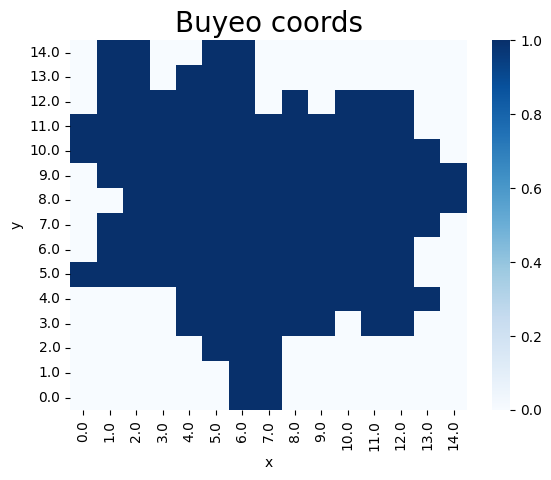

In [262]:
# 부여가 포함된 좌표만 걸러내기
# 인구분포 데이터와 화재 데이터를 결합하여 부여에 해당하는 좌표 얻기
df_pop_xy = df_pop.loc[:, ['x', 'y']]
df_fire_xy = df_fire.loc[:, ['x', 'y']]
df_buyeo = pd.concat([df_pop_xy, df_fire_xy])
df_buyeo = df_buyeo.drop_duplicates()
df_buyeo['val'] = 1
df_buyeo_heatmap = df_buyeo.pivot(index='y', columns='x', values='val').sort_index(ascending=False).fillna(0)
df_buyeo = df_buyeo.loc[:, ['x', 'y']]
ax = sns.heatmap(df_buyeo_heatmap, cmap='Blues')
plt.title('Buyeo coords', fontsize=20)
plt.show()

In [263]:
# 11년치 날씨데이터 평균내서 23년도 날씨로 예측
df_fut_weather = df_weather.groupby(['월']).mean().drop(columns=['년', '일']).reset_index()
df_fut_weather

,월,평균기온(°C),최저기온(°C),최고기온(°C),평균 상대습도\n(%),일강수량(mm),평균 풍속(m/s)
0,1,-1.385337,-6.638710,4.651320,70.536364,0.769208,1.095015
1,2,0.779100,-4.882637,6.999035,64.272669,1.268810,1.366238
2,3,6.487977,0.058944,13.654839,65.741056,1.687390,1.443695
3,4,12.153030,5.453333,19.492727,65.420909,3.007273,1.539697
4,5,17.850733,11.487683,24.984751,67.973314,2.524047,1.448387
5,6,22.465455,17.652727,28.330303,74.122424,3.181818,1.312727
6,7,25.499413,22.031378,30.218182,81.592082,8.357771,1.343988
7,8,26.061584,22.282991,30.991789,80.671554,8.670968,1.328446
8,9,20.905455,16.365152,26.711212,78.428485,4.710606,1.191515
9,10,14.124047,8.520235,21.224340,76.725513,2.747214,1.041935


In [264]:
# 좌표별 임야 화재 횟수 세기
df_field_fire = df_fire[df_fire['화재구분'] == '임야'].groupby(['x', 'y']).count().loc[:, ['화재구분']].reset_index()
df_field_fire.head()

,x,y,화재구분
0,0.0,5.0,1
1,0.0,10.0,2
2,1.0,5.0,3
3,1.0,6.0,1
4,1.0,7.0,2


In [266]:
# 좌표별 비닐하우스 화재 횟수 세기
df_green_fire = df_fire[df_fire['화재구분'] == '비닐하우스'].groupby(['x', 'y']).count().loc[:, ['화재구분']].reset_index()
df_green_fire.head()

,x,y,화재구분
0,0.0,11.0,2
1,1.0,5.0,1
2,1.0,6.0,2
3,1.0,10.0,1
4,1.0,11.0,1


In [267]:
# 날짜와 좌표의 모든 조합 구하기
import itertools

year = [2023]
month = list(np.arange(start=1, stop=13))
full_date = list(itertools.product(year, month))
buyeo_coords = df_buyeo.values.tolist()

date_coords = list(itertools.product(full_date, buyeo_coords))
len(date_coords)

1632

In [268]:
pred_feats = []

for date_coord in date_coords:
    feat = []
    # 날짜 및 좌표부터 추가: 년, 월, x, y
    feat.append(date_coord[0][0]) 
    feat.append(date_coord[0][1]) 
    feat.append(date_coord[1][0])
    feat.append(date_coord[1][1])

    # 인구수비율 및 노인인구수비율 추가: 인구수비율, 60세이상노인인구수비율
    pop_result =  df_pop[
        (df_pop['연도'] == 2022) &
        (df_pop['x'] == date_coord[1][0]) &
        (df_pop['y'] == date_coord[1][1])
    ]

    if len(pop_result) == 0:
        feat.append(0.)
        feat.append(0.)
    else:
        feat.append(pop_result.iloc[0]['인구수비율'])
        feat.append(pop_result.iloc[0]['60세이상노인인구수비율'])

    # 날짜 및 좌표별 창고개수 추가: 창고개수
    storage_date = int(str(2022) + str('{:02d}'.format(date_coord[0][1])) + str(15))
    storage_result = df_buildings.loc[
        (df_buildings['x'] == date_coord[1][0]) &
        (df_buildings['y'] == date_coord[1][1]) &
        (df_buildings['신고일'] <= storage_date) & 
        (df_buildings['실질적철거일'] >= storage_date) &
        (df_buildings['기타용도'] == '창고')
    ]

    feat.append(len(storage_result))

    # 날짜 및 좌표별 축사, 균사개수 추가: 축균사개수
    barn_spawn_date = int(str(2022) + str('{:02d}'.format(date_coord[0][1])) + str(15))
    barn_spawn_result = df_buildings.loc[
        (df_buildings['x'] == date_coord[1][0]) &
        (df_buildings['y'] == date_coord[1][1]) &
        (df_buildings['신고일'] <= barn_spawn_date) & 
        (df_buildings['실질적철거일'] >= barn_spawn_date) &
        ((df_buildings['기타용도'] == '축사') | (df_buildings['기타용도'] == '균사'))
    ]

    feat.append(len(barn_spawn_result))
    
    # 날씨 데이터 추가: 평균기온, 최저기온, 최고기온, 평균 상대습도, 일강수량, 평균 풍속
    weather_result = df_fut_weather[
        df_fut_weather['월'] == date_coord[0][1]
    ]

    feat.append(weather_result.iloc[0]['평균기온(°C)'])
    feat.append(weather_result.iloc[0]['최저기온(°C)'])
    feat.append(weather_result.iloc[0]['최고기온(°C)'])
    feat.append(weather_result.iloc[0]['평균 상대습도\n(%)'])
    feat.append(weather_result.iloc[0]['일강수량(mm)'])
    feat.append(weather_result.iloc[0]['평균 풍속(m/s)'])

    # 좌표별 임야화재횟수 추가: 임야화재횟수
    field_result = df_field_fire[
        (df_field_fire['x'] == date_coord[1][0]) & 
        (df_field_fire['y'] == date_coord[1][1])
    ]

    if len(field_result) == 0:
        feat.append(0.)
    else:
        feat.append(field_result.iloc[0]['화재구분'])

    # 좌표별 비닐하우스화재횟수 추가: 비닐하우스화재횟수
    green_result = df_green_fire[
        (df_green_fire['x'] == date_coord[1][0]) & 
        (df_green_fire['y'] == date_coord[1][1])
    ]

    if len(green_result) == 0:
        feat.append(0.)
    else:
        feat.append(green_result.iloc[0]['화재구분'])

    pred_feats.append(feat)

In [269]:
# 년, 월, x, y, 인구수비율, 60세이상노인인구수비율, 창고개수, 축균사개수, 평균기온, 최저기온, 최고기온, 평균상대습도, 
# 일강수량, 평균풍속, 임야화재횟수, 비닐하우스화재횟수
fut_df = pd.DataFrame(pred_feats, columns=[
    'year', 'month', 'x', 'y', 'pop_rate', 'old_pop_rate', 'sto_num', 'barn_spwn_num', 'avg_temp', 'min_temp', 'max_temp', 'avg_hum', 
    'daily_pre', 'avg_wind', 'field_fire', 'green_fire'
])
print(len(fut_df))
fut_df.head()

1632


,year,month,x,y,pop_rate,old_pop_rate,sto_num,barn_spwn_num,avg_temp,min_temp,max_temp,avg_hum,daily_pre,avg_wind,field_fire,green_fire
0,2023,1,0.0,11.0,0.010901,0.012014,5,0,-1.385337,-6.63871,4.65132,70.536364,0.769208,1.095015,0.0,0.0
1,2023,1,1.0,5.0,0.004584,0.006429,8,1,-1.385337,-6.63871,4.65132,70.536364,0.769208,1.095015,3.0,3.0
2,2023,1,1.0,6.0,0.005604,0.007338,8,2,-1.385337,-6.63871,4.65132,70.536364,0.769208,1.095015,1.0,1.0
3,2023,1,1.0,7.0,0.002089,0.002987,6,1,-1.385337,-6.63871,4.65132,70.536364,0.769208,1.095015,2.0,2.0
4,2023,1,1.0,9.0,0.001263,0.001916,7,0,-1.385337,-6.63871,4.65132,70.536364,0.769208,1.095015,0.0,0.0


In [270]:
# 스케일링 위해 전체 데이터 가져오기
full_df = pd.read_csv('./data/non_scaled_data.csv').drop(columns=['fire'])
print(len(full_df))
full_df.head()

17952


,year,month,x,y,pop_rate,old_pop_rate,sto_num,barn_spwn_num,avg_temp,min_temp,max_temp,avg_hum,daily_pre,avg_wind,field_fire,green_fire
0,2012,1,0.0,11.0,0.012300,0.012723,0,0,-1.4,-6.1,0.9,73.0,1.5,1.6,0.0,0.0
1,2012,1,1.0,5.0,0.004109,0.007010,0,0,-1.4,-6.1,0.9,73.0,1.5,1.6,3.0,3.0
2,2012,1,1.0,6.0,0.005297,0.008671,0,0,-1.4,-6.1,0.9,73.0,1.5,1.6,1.0,1.0
3,2012,1,1.0,7.0,0.001939,0.002958,0,0,-1.4,-6.1,0.9,73.0,1.5,1.6,2.0,2.0
4,2012,1,1.0,9.0,0.001038,0.001661,0,0,-1.4,-6.1,0.9,73.0,1.5,1.6,0.0,0.0


In [271]:
# 전체 데이터와 예측할 데이터를 같이 묶기
fut_df = pd.concat([fut_df, full_df], axis=0)

In [272]:
# 전체 데이터를 포함하여 MinMaxScaler로 스케일링
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
fut_df['x'] = scaler.fit_transform(fut_df['x'].values.reshape(-1, 1))
fut_df['y'] = scaler.fit_transform(fut_df['y'].values.reshape(-1, 1))
fut_df['pop_rate'] = scaler.fit_transform(fut_df['pop_rate'].values.reshape(-1, 1))
fut_df['old_pop_rate'] = scaler.fit_transform(fut_df['old_pop_rate'].values.reshape(-1, 1))
fut_df['sto_num'] = scaler.fit_transform(fut_df['sto_num'].values.reshape(-1, 1))
fut_df['barn_spwn_num'] = scaler.fit_transform(fut_df['barn_spwn_num'].values.reshape(-1, 1))
fut_df['avg_temp'] = scaler.fit_transform(fut_df['avg_temp'].values.reshape(-1, 1))
fut_df['min_temp'] = scaler.fit_transform(fut_df['min_temp'].values.reshape(-1, 1))
fut_df['max_temp'] = scaler.fit_transform(fut_df['max_temp'].values.reshape(-1, 1))
fut_df['avg_hum'] = scaler.fit_transform(fut_df['avg_hum'].values.reshape(-1, 1))
fut_df['daily_pre'] = scaler.fit_transform(fut_df['daily_pre'].values.reshape(-1, 1))
fut_df['avg_wind'] = scaler.fit_transform(fut_df['avg_wind'].values.reshape(-1, 1))
fut_df['field_fire'] = scaler.fit_transform(fut_df['field_fire'].values.reshape(-1, 1))
fut_df['green_fire'] = scaler.fit_transform(fut_df['green_fire'].values.reshape(-1, 1))

In [273]:
# 예측할 데이터만 떼서 미래데이터 준비
fut_df = fut_df.iloc[:1632].drop(columns=['year'])
fut_df.head()

,month,x,y,pop_rate,old_pop_rate,sto_num,barn_spwn_num,avg_temp,min_temp,max_temp,avg_hum,daily_pre,avg_wind,field_fire,green_fire
0,1,0.000000,0.785714,0.087905,0.165105,0.094340,0.000000,0.145458,0.13392,0.168721,0.495154,0.004113,0.240914,0.000000,0.000000
1,1,0.071429,0.357143,0.036964,0.088353,0.150943,0.166667,0.145458,0.13392,0.168721,0.495154,0.004113,0.240914,0.214286,0.214286
2,1,0.071429,0.428571,0.045193,0.100848,0.150943,0.333333,0.145458,0.13392,0.168721,0.495154,0.004113,0.240914,0.071429,0.071429
3,1,0.071429,0.500000,0.016850,0.041053,0.113208,0.166667,0.145458,0.13392,0.168721,0.495154,0.004113,0.240914,0.142857,0.142857
4,1,0.071429,0.642857,0.010188,0.026328,0.132075,0.000000,0.145458,0.13392,0.168721,0.495154,0.004113,0.240914,0.000000,0.000000


In [274]:
# 데이터로 예측 진행
# 오버샘플링 랜덤포레스트 사용
fut_y = rf_best_over.predict(fut_df)
#fut_y = gb_best_over.predict(fut_df)
fut_df['fire'] = fut_y
fut_df.head()

,month,x,y,pop_rate,old_pop_rate,sto_num,barn_spwn_num,avg_temp,min_temp,max_temp,avg_hum,daily_pre,avg_wind,field_fire,green_fire,fire
0,1,0.000000,0.785714,0.087905,0.165105,0.094340,0.000000,0.145458,0.13392,0.168721,0.495154,0.004113,0.240914,0.000000,0.000000,0.0
1,1,0.071429,0.357143,0.036964,0.088353,0.150943,0.166667,0.145458,0.13392,0.168721,0.495154,0.004113,0.240914,0.214286,0.214286,0.0
2,1,0.071429,0.428571,0.045193,0.100848,0.150943,0.333333,0.145458,0.13392,0.168721,0.495154,0.004113,0.240914,0.071429,0.071429,0.0
3,1,0.071429,0.500000,0.016850,0.041053,0.113208,0.166667,0.145458,0.13392,0.168721,0.495154,0.004113,0.240914,0.142857,0.142857,0.0
4,1,0.071429,0.642857,0.010188,0.026328,0.132075,0.000000,0.145458,0.13392,0.168721,0.495154,0.004113,0.240914,0.000000,0.000000,0.0


In [275]:
# 예측한 데이터들의 좌표를 스케일링 이전으로 변환
df_map = fut_df.loc[:, ['month', 'x', 'y', 'fire']]
df_map['x'] = (df_map['x'] * 14).apply(lambda x: np.ceil(x))
df_map['y'] = (df_map['y'] * 14).apply(lambda x: np.ceil(x))
df_map.head()

,month,x,y,fire
0,1,0.0,11.0,0.0
1,1,1.0,5.0,0.0
2,1,1.0,6.0,0.0
3,1,1.0,7.0,0.0
4,1,1.0,9.0,0.0


In [84]:
# 화재예측지역은 1, 해당지역 주변지역은 0.5로 변환
check_coord = df_map.loc[:, ['month', 'x', 'y']].values.tolist()
for idx in df_map[df_map['fire'] == 1].index:
    month = df_map.iloc[idx]['month']
    x = df_map.iloc[idx]['x']
    y = df_map.iloc[idx]['y']
    if [month, x+1, y] in check_coord:
        i = df_map[(df_map['month'] == month) & (df_map['x'] == x+1) & (df_map['y'] == y)].index[0]
        if df_map.iloc[i, df_map.columns.get_loc('fire')] != 1:
            df_map.iloc[i, df_map.columns.get_loc('fire')] = 0.5
    if [month, x-1, y] in check_coord:
        i = df_map[(df_map['month'] == month) & (df_map['x'] == x-1) & (df_map['y'] == y)].index[0]
        if df_map.iloc[i, df_map.columns.get_loc('fire')] != 1:
            df_map.iloc[i, df_map.columns.get_loc('fire')] = 0.5
    if [month, x, y+1] in check_coord:
        i = df_map[(df_map['month'] == month) & (df_map['x'] == x) & (df_map['y'] == y+1)].index[0]
        if df_map.iloc[i, df_map.columns.get_loc('fire')] != 1:
            df_map.iloc[i, df_map.columns.get_loc('fire')] = 0.5
    if [month, x, y-1] in check_coord:
        i = df_map[(df_map['month'] == month) & (df_map['x'] == x) & (df_map['y'] == y-1)].index[0]
        if df_map.iloc[i, df_map.columns.get_loc('fire')] != 1:
            df_map.iloc[i, df_map.columns.get_loc('fire')] = 0.5
    if [month, x+1, y+1] in check_coord:
        i = df_map[(df_map['month'] == month) & (df_map['x'] == x+1) & (df_map['y'] == y+1)].index[0]
        if df_map.iloc[i, df_map.columns.get_loc('fire')] != 1:
            df_map.iloc[i, df_map.columns.get_loc('fire')] = 0.5
    if [month, x+1, y-1] in check_coord:
        i = df_map[(df_map['month'] == month) & (df_map['x'] == x+1) & (df_map['y'] == y-1)].index[0]
        if df_map.iloc[i, df_map.columns.get_loc('fire')] != 1:
            df_map.iloc[i, df_map.columns.get_loc('fire')] = 0.5
    if [month, x-1, y+1] in check_coord:
        i = df_map[(df_map['month'] == month) & (df_map['x'] == x-1) & (df_map['y'] == y+1)].index[0]
        if df_map.iloc[i, df_map.columns.get_loc('fire')] != 1:
            df_map.iloc[i, df_map.columns.get_loc('fire')] = 0.5
    if [month, x-1, y-1] in check_coord:
        i = df_map[(df_map['month'] == month) & (df_map['x'] == x-1) & (df_map['y'] == y-1)].index[0]
        if df_map.iloc[i, df_map.columns.get_loc('fire')] != 1:
            df_map.iloc[i, df_map.columns.get_loc('fire')] = 0.5

In [85]:
# 월별 화재데이터 예측
map_heatmap_1 = df_map[df_map['month'] == 1].pivot(index='y', columns='x', values='fire').sort_index(ascending=False).fillna(0)
map_heatmap_2 = df_map[df_map['month'] == 2].pivot(index='y', columns='x', values='fire').sort_index(ascending=False).fillna(0)
map_heatmap_3 = df_map[df_map['month'] == 3].pivot(index='y', columns='x', values='fire').sort_index(ascending=False).fillna(0)
map_heatmap_4 = df_map[df_map['month'] == 4].pivot(index='y', columns='x', values='fire').sort_index(ascending=False).fillna(0)
map_heatmap_5 = df_map[df_map['month'] == 5].pivot(index='y', columns='x', values='fire').sort_index(ascending=False).fillna(0)
map_heatmap_6 = df_map[df_map['month'] == 6].pivot(index='y', columns='x', values='fire').sort_index(ascending=False).fillna(0)
map_heatmap_7 = df_map[df_map['month'] == 7].pivot(index='y', columns='x', values='fire').sort_index(ascending=False).fillna(0)
map_heatmap_8 = df_map[df_map['month'] == 8].pivot(index='y', columns='x', values='fire').sort_index(ascending=False).fillna(0)
map_heatmap_9 = df_map[df_map['month'] == 9].pivot(index='y', columns='x', values='fire').sort_index(ascending=False).fillna(0)
map_heatmap_10 = df_map[df_map['month'] == 10].pivot(index='y', columns='x', values='fire').sort_index(ascending=False).fillna(0)
map_heatmap_11 = df_map[df_map['month'] == 11].pivot(index='y', columns='x', values='fire').sort_index(ascending=False).fillna(0)
map_heatmap_12 = df_map[df_map['month'] == 12].pivot(index='y', columns='x', values='fire').sort_index(ascending=False).fillna(0)

Text(0.5, 1.0, '2023.12')

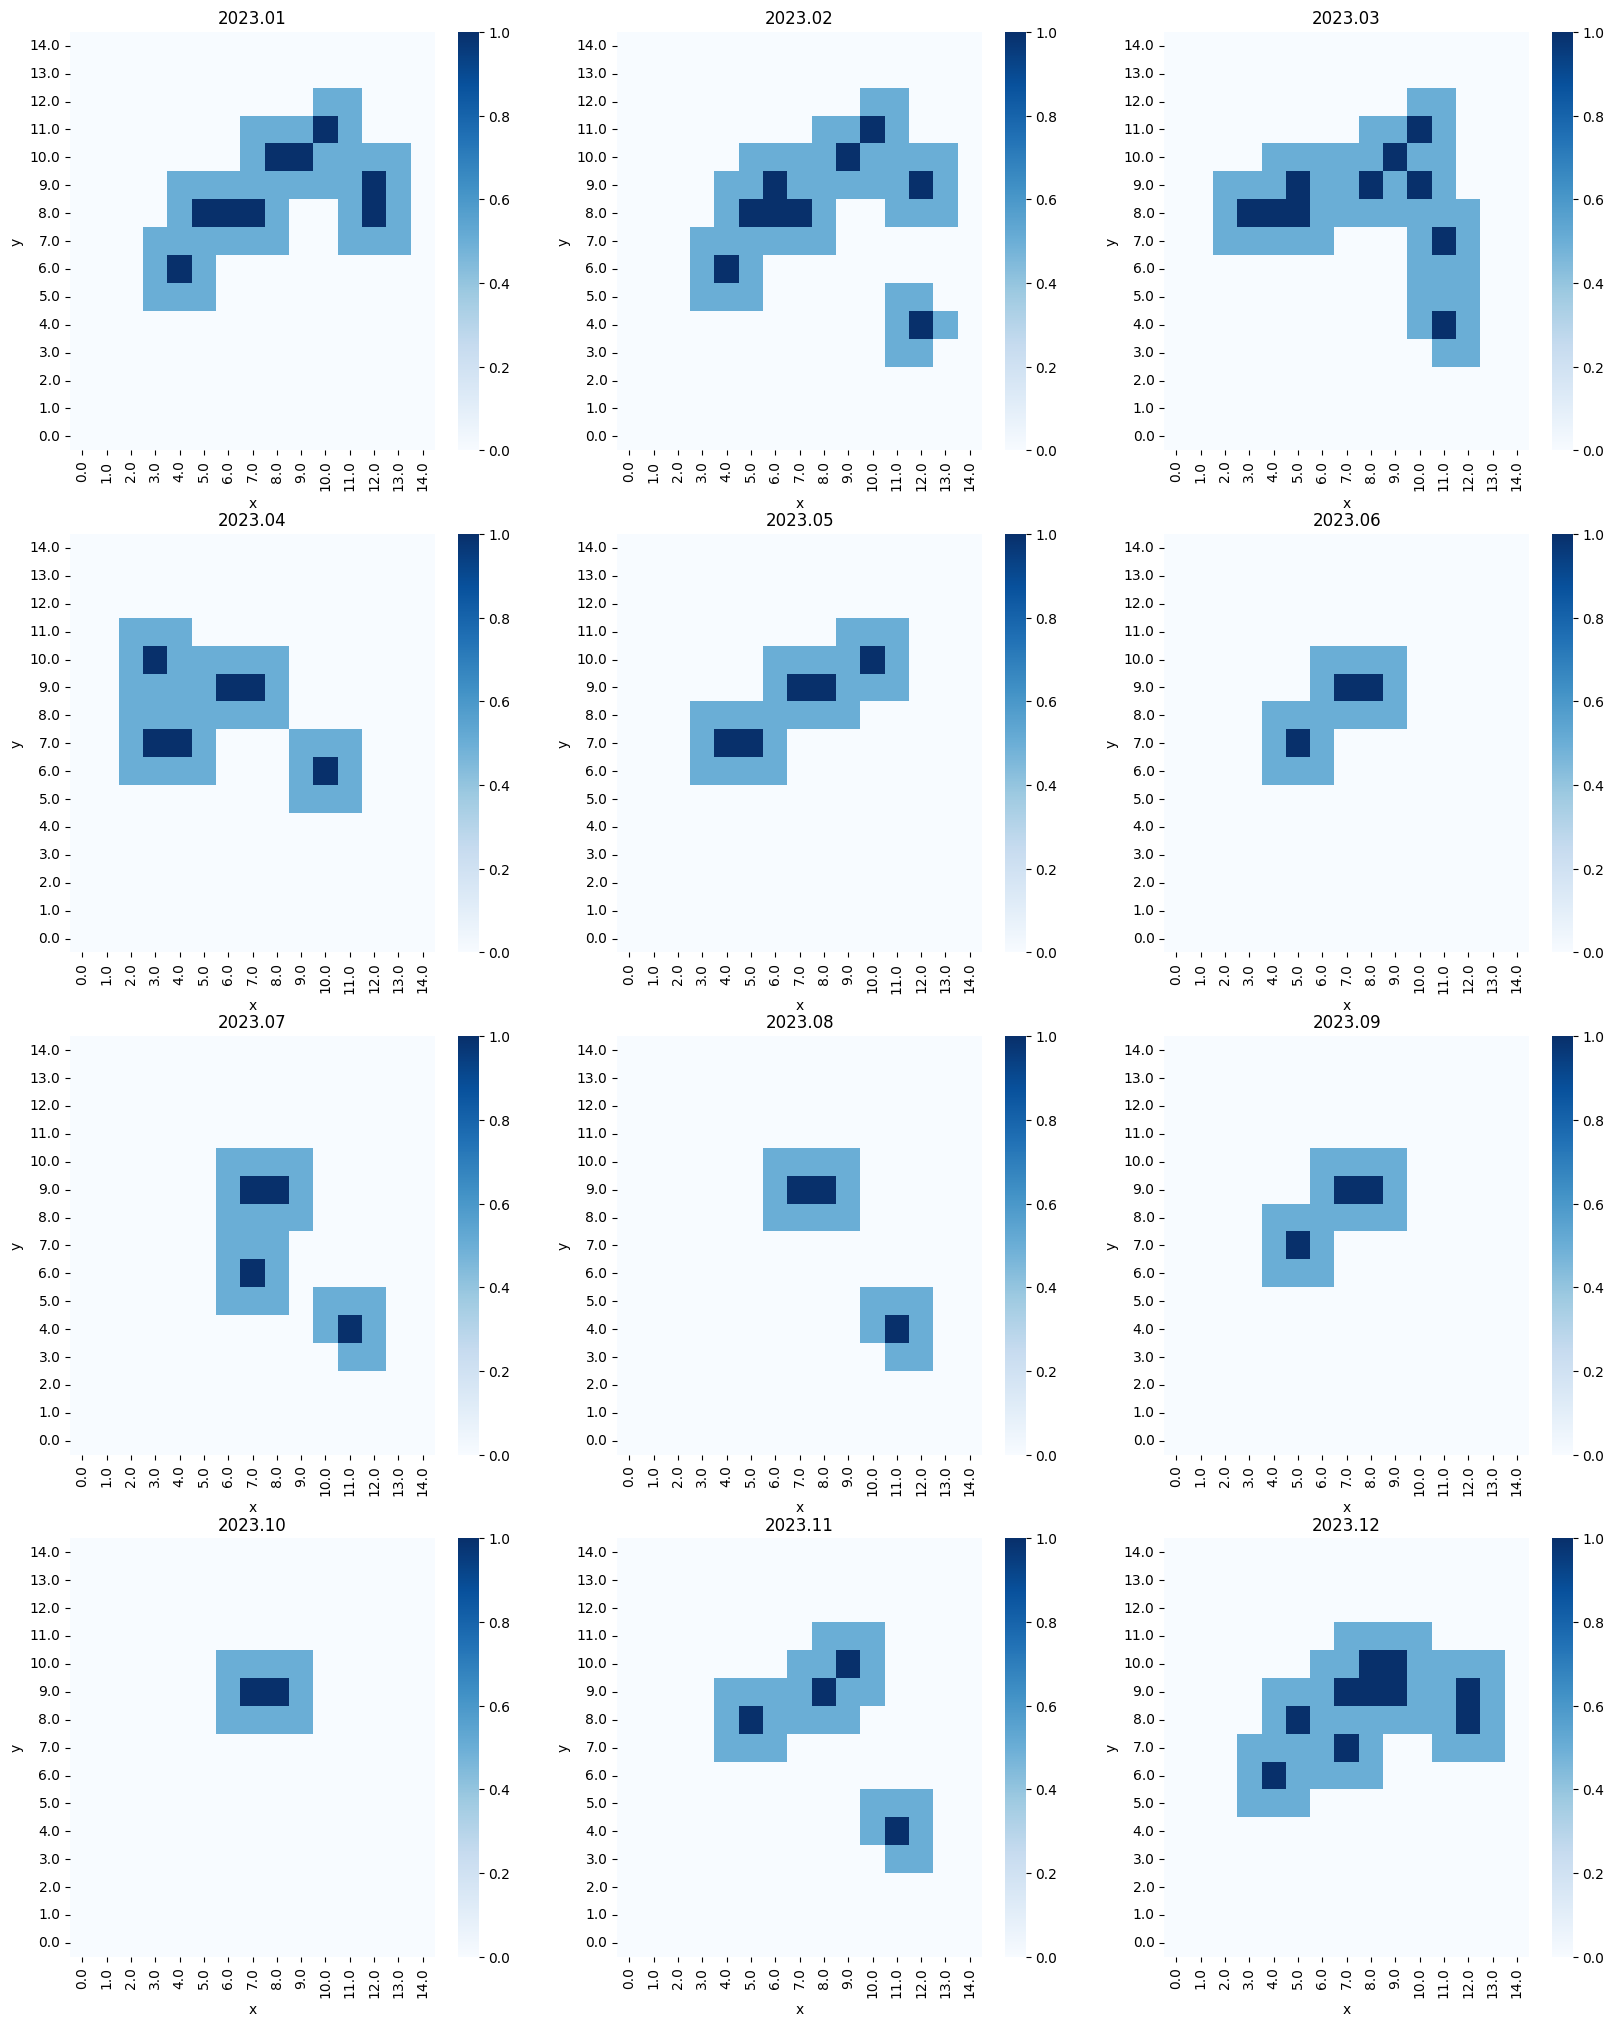

In [86]:
fig, ax = plt.subplots(ncols=3, nrows=4, figsize=(20, 25))

sns.heatmap(map_heatmap_1, cmap='Blues', ax=ax[0][0])
sns.heatmap(map_heatmap_2, cmap='Blues', ax=ax[0][1])
sns.heatmap(map_heatmap_3, cmap='Blues', ax=ax[0][2])
sns.heatmap(map_heatmap_4, cmap='Blues', ax=ax[1][0])
sns.heatmap(map_heatmap_5, cmap='Blues', ax=ax[1][1])
sns.heatmap(map_heatmap_6, cmap='Blues', ax=ax[1][2])
sns.heatmap(map_heatmap_7, cmap='Blues', ax=ax[2][0])
sns.heatmap(map_heatmap_8, cmap='Blues', ax=ax[2][1])
sns.heatmap(map_heatmap_9, cmap='Blues', ax=ax[2][2])
sns.heatmap(map_heatmap_10, cmap='Blues', ax=ax[3][0])
sns.heatmap(map_heatmap_11, cmap='Blues', ax=ax[3][1])
sns.heatmap(map_heatmap_12, cmap='Blues', ax=ax[3][2])

ax[0][0].set_title('2023.01')
ax[0][1].set_title('2023.02')
ax[0][2].set_title('2023.03')
ax[1][0].set_title('2023.04')
ax[1][1].set_title('2023.05')
ax[1][2].set_title('2023.06')
ax[2][0].set_title('2023.07')
ax[2][1].set_title('2023.08')
ax[2][2].set_title('2023.09')
ax[3][0].set_title('2023.10')
ax[3][1].set_title('2023.11')
ax[3][2].set_title('2023.12')

In [87]:
# 예측된 2023년 화재 정보 저장
df_map.to_csv('./data/2023_prediction.csv', encoding='utf-8-sig', index=False)

# 4. 지도에 예측된 화재격자 표시

In [88]:
import folium
import numpy as np
import pandas as pd

In [89]:
# 2023년 예측한 결과 데이터 불러오기
df_map = pd.read_csv('./data/2023_prediction.csv')
#df_map = df_map[df_map['month'] > 6]
df_map.head()

,month,x,y,fire
0,1,0.0,11.0,0.0
1,1,1.0,5.0,0.0
2,1,1.0,6.0,0.0
3,1,1.0,7.0,0.0
4,1,1.0,9.0,0.0


In [90]:
# 부여 동서남북 가장 끝 좌표
LOWER = 36.0721
LEFT = 126.6796
UPPER = 36.3865
RIGHT = 127.07


In [91]:
# 15, 15 좌표를 원래의 위도, 경도 좌표계로 변환
df_map['lon'] = (RIGHT - LEFT) * df_map['x'] / 15. + LEFT 
df_map['lat'] = (UPPER - LOWER) * df_map['y'] / 15. + LOWER
df_map.head()

,month,x,y,fire,lon,lat
0,1,0.0,11.0,0.0,126.679600,36.30266
1,1,1.0,5.0,0.0,126.705627,36.17690
2,1,1.0,6.0,0.0,126.705627,36.19786
3,1,1.0,7.0,0.0,126.705627,36.21882
4,1,1.0,9.0,0.0,126.705627,36.26074


In [92]:
# 웹에서 사용할 csv 파일 위해 각 격자별 남서, 북동 좌표 계산 후 저장
xs = (RIGHT - LEFT) / 15.
ys = (UPPER - LOWER) / 15.

df_map['sw_lat'] = df_map['lat']
df_map['sw_lon'] = df_map['lon']

df_map['ne_lat'] = df_map['lat'] + ys
df_map['ne_lon'] = df_map['lon'] + xs

df_map.head()

,month,x,y,fire,lon,lat,sw_lat,sw_lon,ne_lat,ne_lon
0,1,0.0,11.0,0.0,126.679600,36.30266,36.30266,126.679600,36.32362,126.705627
1,1,1.0,5.0,0.0,126.705627,36.17690,36.17690,126.705627,36.19786,126.731653
2,1,1.0,6.0,0.0,126.705627,36.19786,36.19786,126.705627,36.21882,126.731653
3,1,1.0,7.0,0.0,126.705627,36.21882,36.21882,126.705627,36.23978,126.731653
4,1,1.0,9.0,0.0,126.705627,36.26074,36.26074,126.705627,36.28170,126.731653


In [93]:
# 웹에서 사용할 예측결과 저장
df_map.loc[:, ['month', 'sw_lat', 'sw_lon', 'ne_lat', 'ne_lon', 'fire']].to_csv('./data/2023_prediction_web.csv', encoding='utf-8-sig', index=False)

In [94]:
# 사각형 폴리곤 구성 꼭짓점 계산
def get_rectangle_points(lat, lon):
    x_size = (RIGHT - LEFT) / 15.
    y_size = (UPPER - LOWER) / 15.

    points = [
        [lat, lon],
        [lat, lon + x_size],
        [lat + y_size, lon + x_size],
        [lat + y_size, lon],
    ]

    return points

In [108]:
# month 변수 조정하여 2023.07~2023.12까지 화재 예측
gmap = folium.Map(location=((LOWER + UPPER) / 2, (LEFT + RIGHT) / 2), zoom_start=10)

month = 10

for idx in df_map[df_map['month'] == month].index:
    points = get_rectangle_points(df_map.loc[idx, 'lat'], df_map.loc[idx, 'lon'])

    if df_map.loc[idx, 'fire'] == 0.:
        folium.Polygon(locations=points, tooltip='Fire', opacity=0.3).add_to(gmap)
    elif df_map.loc[idx, 'fire'] == 0.5:
        folium.Polygon(locations=points, tooltip='Fire', opacity=0.3, fill=True, fillColor='red', fillOpacity=0.2).add_to(gmap)
    else:
        folium.Polygon(locations=points, tooltip='Fire', opacity=0.3, fill=True, fillColor='red', fillOpacity=0.6).add_to(gmap)

gmap

# 5. 실제 데이터와의 비교

In [10]:
import folium
import json
import requests
import re

In [11]:
# 2023년 1월~6월 화재데이터 불러오기
df_2023 = pd.read_csv('./data/fire_2023_01_06.csv')

In [12]:
# 사용할 컬럼만 분해
df_2023 = df_2023.loc[:, ['화재발생(월)', '시도', '시군구', '읍면동', '지번리', '세부주소']]
df_2023.head()

,화재발생(월),시도,시군구,읍면동,지번리,세부주소
0,1,충청남도,부여군,규암면,신성리,2121 주택 마당
1,1,충청남도,부여군,은산면,가중리,1111
2,1,충청남도,부여군,홍산면,무정리,301
3,1,충청남도,부여군,세도면,장산리,1064
4,1,충청남도,부여군,내산면,지티리,1262


In [13]:
# 주소 병합
df_2023['군면리'] = df_2023['시군구'] + ' ' + df_2023['읍면동'] + ' ' + df_2023['지번리']
df_addr_2023 = df_2023[['군면리']]
df_addr_2023['세부주소'] = df_2023['세부주소'].apply(lambda x: x.split(' ')[0])
df_addr_2023.head()

,군면리,세부주소
0,부여군 규암면 신성리,2121
1,부여군 은산면 가중리,1111
2,부여군 홍산면 무정리,301
3,부여군 세도면 장산리,1064
4,부여군 내산면 지티리,1262


In [14]:
# 카카오맵 API
API_KEY = 'c8d2487b6ee1ee531c4b6899126efe7f'
headers = {'Authorization' : 'KakaoAK '+API_KEY}
headers

{'Authorization': 'KakaoAK c8d2487b6ee1ee531c4b6899126efe7f'}

In [15]:
# 위도 및 경도를 가져오는 함수
def getLat(addr):
    url = 'https://dapi.kakao.com/v2/local/search/address.json?query=' + addr
    result = json.loads(str(requests.get(url, headers=headers).text))
    if len(result['documents']) == 0:
        new_addr = re.sub(r'[0-9]+', '', addr)
        url = 'https://dapi.kakao.com/v2/local/search/address.json?query=' + new_addr
        result = json.loads(str(requests.get(url, headers=headers).text))

    match_first = result['documents'][0]['address']

    return float(match_first['y'])

def getLng(addr):
    url = 'https://dapi.kakao.com/v2/local/search/address.json?query=' + addr
    result = json.loads(str(requests.get(url, headers=headers).text))
    if len(result['documents']) == 0:
        new_addr = re.sub(r'[0-9]+', '', addr)
        url = 'https://dapi.kakao.com/v2/local/search/address.json?query=' + new_addr
        result = json.loads(str(requests.get(url, headers=headers).text))
        
    match_first = result['documents'][0]['address']
    return float(match_first['x'])

In [16]:
# 주소를 위도 경도로 변환
for i in range(len(df_addr_2023)):
    try:
        lng = getLng(df_addr_2023['군면리'][i] + df_addr_2023['세부주소'][i])
        lat = getLat(df_addr_2023['군면리'][i] + df_addr_2023['세부주소'][i])
        df_addr_2023.loc[i,['경도']] = lng
        df_addr_2023.loc[i,['위도']] = lat

    except:
        print('error',i)
        
    
    if i%100 == 0:
        print('{} 번째 주소에 대한 좌표정보 불러오는 중...'.format(i)) 

0 번째 주소에 대한 좌표정보 불러오는 중...
error 22


In [17]:
df_2023['경도'] = df_addr_2023['경도']
df_2023['위도'] = df_addr_2023['위도']
df_2023.head()

,화재발생(월),시도,시군구,읍면동,지번리,세부주소,군면리,경도,위도
0,1,충청남도,부여군,규암면,신성리,2121 주택 마당,부여군 규암면 신성리,126.881966,36.320330
1,1,충청남도,부여군,은산면,가중리,1111,부여군 은산면 가중리,126.844634,36.299416
2,1,충청남도,부여군,홍산면,무정리,301,부여군 홍산면 무정리,126.782041,36.240264
3,1,충청남도,부여군,세도면,장산리,1064,부여군 세도면 장산리,126.985269,36.177371
4,1,충청남도,부여군,내산면,지티리,1262,부여군 내산면 지티리,126.738454,36.283922


In [18]:
# 결측치 제거
print(len(df_2023))
df_2023 = df_2023.dropna(axis=0).reset_index(drop=True)
print(len(df_2023))

50
49


In [19]:
# 부여 동서남북 가장 끝 좌표
LOWER = 36.0721
LEFT = 126.6796
UPPER = 36.3865
RIGHT = 127.07

In [20]:
# 위도, 경도 15, 15 좌표계로 변환
df_2023['x'] = df_2023['경도'].astype(float).map(lambda x: np.trunc((x - LEFT) / ((RIGHT - LEFT) / 15.)))
df_2023['y'] = df_2023['위도'].astype(float).map(lambda x: np.trunc((x - LOWER) / ((UPPER - LOWER) / 15.)))
df_2023.head()

,화재발생(월),시도,시군구,읍면동,지번리,세부주소,군면리,경도,위도,x,y
0,1,충청남도,부여군,규암면,신성리,2121 주택 마당,부여군 규암면 신성리,126.881966,36.320330,7.0,11.0
1,1,충청남도,부여군,은산면,가중리,1111,부여군 은산면 가중리,126.844634,36.299416,6.0,10.0
2,1,충청남도,부여군,홍산면,무정리,301,부여군 홍산면 무정리,126.782041,36.240264,3.0,8.0
3,1,충청남도,부여군,세도면,장산리,1064,부여군 세도면 장산리,126.985269,36.177371,11.0,5.0
4,1,충청남도,부여군,내산면,지티리,1262,부여군 내산면 지티리,126.738454,36.283922,2.0,10.0


In [44]:
# 필요컬럼만 남기고 저장
df_2023 = df_2023.loc[:, ['화재발생(월)', '경도', '위도', 'x', 'y']]
df_2023.to_csv('./data/pre_real_2023_fire.csv')

In [21]:
# 전처리된 2023년 화재데이터 불러오기
df_2023 = pd.read_csv('./data/pre_real_2023_fire.csv')

In [22]:
# 실제 화재데이터 정렬
df_real = df_2023.groupby(['화재발생(월)', 'x', 'y']).count().reset_index().loc[:, ['화재발생(월)', 'x', 'y']]
df_real['fire'] = 1.
df_real.head()

,화재발생(월),x,y,fire
0,1,2.0,6.0,1.0
1,1,2.0,10.0,1.0
2,1,3.0,7.0,1.0
3,1,3.0,8.0,1.0
4,1,6.0,10.0,1.0


In [23]:
# 데이터파일 불러오기
df_fire = pd.read_csv('./data/preprocessed_fire_data.csv')
df_buildings = pd.read_csv('./data/preprocessed_buildings.csv')
df_pop = pd.read_csv('./data/coorded_old_population.csv')
df_weather = pd.read_csv('./data/preprocessed_weather.csv')

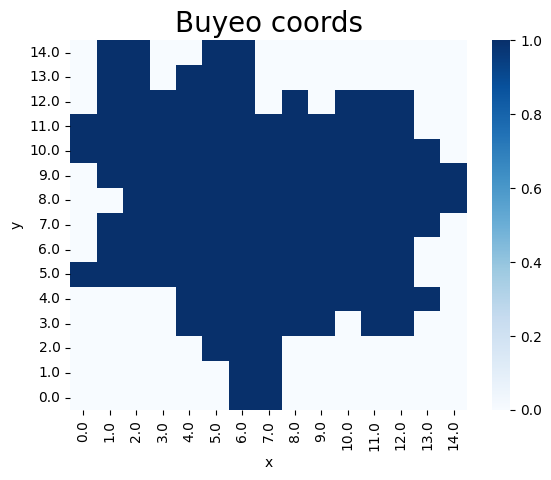

In [24]:
# 부여가 포함된 좌표만 걸러내기
# 인구분포 데이터와 화재 데이터를 결합하여 부여에 해당하는 좌표 얻기
df_pop_xy = df_pop.loc[:, ['x', 'y']]
df_fire_xy = df_fire.loc[:, ['x', 'y']]
df_buyeo = pd.concat([df_pop_xy, df_fire_xy])
df_buyeo = df_buyeo.drop_duplicates()
df_buyeo['val'] = 1
df_buyeo_heatmap = df_buyeo.pivot(index='y', columns='x', values='val').sort_index(ascending=False).fillna(0)
df_buyeo = df_buyeo.loc[:, ['x', 'y']]
ax = sns.heatmap(df_buyeo_heatmap, cmap='Blues')
plt.title('Buyeo coords', fontsize=20)
plt.show()

In [25]:
# 날짜와 좌표의 모든 조합 구하기
import itertools

year = [2023]
month = list(np.arange(start=1, stop=7))
full_date = list(itertools.product(year, month))
buyeo_coords = df_buyeo.values.tolist()

date_coords = list(itertools.product(full_date, buyeo_coords))
len(date_coords)

816

In [26]:
# 모든 조합의 화재 발생여부 조사
real_feats = []

for date_coord in date_coords:
    feat = []
    # 날짜 및 좌표부터 추가: 년, 월, x, y
    feat.append(date_coord[0][0]) 
    feat.append(date_coord[0][1]) 
    feat.append(date_coord[1][0])
    feat.append(date_coord[1][1])

    # 인구수비율 및 노인인구수비율 추가: 인구수비율, 60세이상노인인구수비율
    fire_result =  df_real[
        (df_real['화재발생(월)'] == date_coord[0][1]) &
        (df_real['x'] == date_coord[1][0]) &
        (df_real['y'] == date_coord[1][1])
    ]

    if len(fire_result) == 0:
        feat.append(0.)
    else:
        feat.append(1.)



    real_feats.append(feat)

In [29]:
# 조사 결과를 데이터프레임으로 변환
df_real = pd.DataFrame(real_feats, columns=[
    'year', 'month', 'x', 'y', 'fire'
])
df_real = df_real.loc[:, ['month', 'x', 'y', 'fire']]
print(len(df_real))
df_real.head()

816


,month,x,y,fire
0,1,0.0,11.0,0.0
1,1,1.0,5.0,0.0
2,1,1.0,6.0,0.0
3,1,1.0,7.0,0.0
4,1,1.0,9.0,0.0


In [30]:
# 모델 기반으로 화재예측한 결과 불러오기
df_pred = pd.read_csv('./data/2023_prediction.csv')

In [78]:
# 화재예측지역은 1, 해당지역 주변지역은 0.5로 변환
df_pred = df_pred[df_pred['month'] <= 6]
check_coord = df_pred.loc[:, ['month', 'x', 'y']].values.tolist()
for idx in df_pred[df_pred['fire'] == 1].index:
    month = df_pred.iloc[idx]['month']
    x = df_pred.iloc[idx]['x']
    y = df_pred.iloc[idx]['y']
    if [month, x+1, y] in check_coord:
        i = df_pred[(df_pred['month'] == month) & (df_pred['x'] == x+1) & (df_pred['y'] == y)].index[0]
        if df_pred.iloc[i, df_pred.columns.get_loc('fire')] != 1:
            df_pred.iloc[i, df_pred.columns.get_loc('fire')] = 0.5
    if [month, x-1, y] in check_coord:
        i = df_pred[(df_pred['month'] == month) & (df_pred['x'] == x-1) & (df_pred['y'] == y)].index[0]
        if df_pred.iloc[i, df_pred.columns.get_loc('fire')] != 1:
            df_pred.iloc[i, df_pred.columns.get_loc('fire')] = 0.5
    if [month, x, y+1] in check_coord:
        i = df_pred[(df_pred['month'] == month) & (df_pred['x'] == x) & (df_pred['y'] == y+1)].index[0]
        if df_pred.iloc[i, df_pred.columns.get_loc('fire')] != 1:
            df_pred.iloc[i, df_pred.columns.get_loc('fire')] = 0.5
    if [month, x, y-1] in check_coord:
        i = df_pred[(df_pred['month'] == month) & (df_pred['x'] == x) & (df_pred['y'] == y-1)].index[0]
        if df_pred.iloc[i, df_pred.columns.get_loc('fire')] != 1:
            df_pred.iloc[i, df_pred.columns.get_loc('fire')] = 0.5
    if [month, x+1, y+1] in check_coord:
        i = df_pred[(df_pred['month'] == month) & (df_pred['x'] == x+1) & (df_pred['y'] == y+1)].index[0]
        if df_pred.iloc[i, df_pred.columns.get_loc('fire')] != 1:
            df_pred.iloc[i, df_pred.columns.get_loc('fire')] = 0.5
    if [month, x+1, y-1] in check_coord:
        i = df_pred[(df_pred['month'] == month) & (df_pred['x'] == x+1) & (df_pred['y'] == y-1)].index[0]
        if df_pred.iloc[i, df_pred.columns.get_loc('fire')] != 1:
            df_pred.iloc[i, df_pred.columns.get_loc('fire')] = 0.5
    if [month, x-1, y+1] in check_coord:
        i = df_pred[(df_pred['month'] == month) & (df_pred['x'] == x-1) & (df_pred['y'] == y+1)].index[0]
        if df_pred.iloc[i, df_pred.columns.get_loc('fire')] != 1:
            df_pred.iloc[i, df_pred.columns.get_loc('fire')] = 0.5
    if [month, x-1, y-1] in check_coord:
        i = df_pred[(df_pred['month'] == month) & (df_pred['x'] == x-1) & (df_pred['y'] == y-1)].index[0]
        if df_pred.iloc[i, df_pred.columns.get_loc('fire')] != 1:
            df_pred.iloc[i, df_pred.columns.get_loc('fire')] = 0.5

In [76]:
# 실제 화재 히트맵
real_heatmap_1 = df_real[df_real['month'] == 1].pivot(index='y', columns='x', values='fire').sort_index(ascending=False).fillna(0)
real_heatmap_2 = df_real[df_real['month'] == 2].pivot(index='y', columns='x', values='fire').sort_index(ascending=False).fillna(0)
real_heatmap_3 = df_real[df_real['month'] == 3].pivot(index='y', columns='x', values='fire').sort_index(ascending=False).fillna(0)
real_heatmap_4 = df_real[df_real['month'] == 4].pivot(index='y', columns='x', values='fire').sort_index(ascending=False).fillna(0)
real_heatmap_5 = df_real[df_real['month'] == 5].pivot(index='y', columns='x', values='fire').sort_index(ascending=False).fillna(0)
real_heatmap_6 = df_real[df_real['month'] == 6].pivot(index='y', columns='x', values='fire').sort_index(ascending=False).fillna(0)

# 예측 화제 히트맵
pred_heatmap_1 = df_pred[df_pred['month'] == 1].pivot(index='y', columns='x', values='fire').sort_index(ascending=False).fillna(0)
pred_heatmap_2 = df_pred[df_pred['month'] == 2].pivot(index='y', columns='x', values='fire').sort_index(ascending=False).fillna(0)
pred_heatmap_3 = df_pred[df_pred['month'] == 3].pivot(index='y', columns='x', values='fire').sort_index(ascending=False).fillna(0)
pred_heatmap_4 = df_pred[df_pred['month'] == 4].pivot(index='y', columns='x', values='fire').sort_index(ascending=False).fillna(0)
pred_heatmap_5 = df_pred[df_pred['month'] == 5].pivot(index='y', columns='x', values='fire').sort_index(ascending=False).fillna(0)
pred_heatmap_6 = df_pred[df_pred['month'] == 6].pivot(index='y', columns='x', values='fire').sort_index(ascending=False).fillna(0)

Text(0.5, 1.0, 'Real: 2023.06')

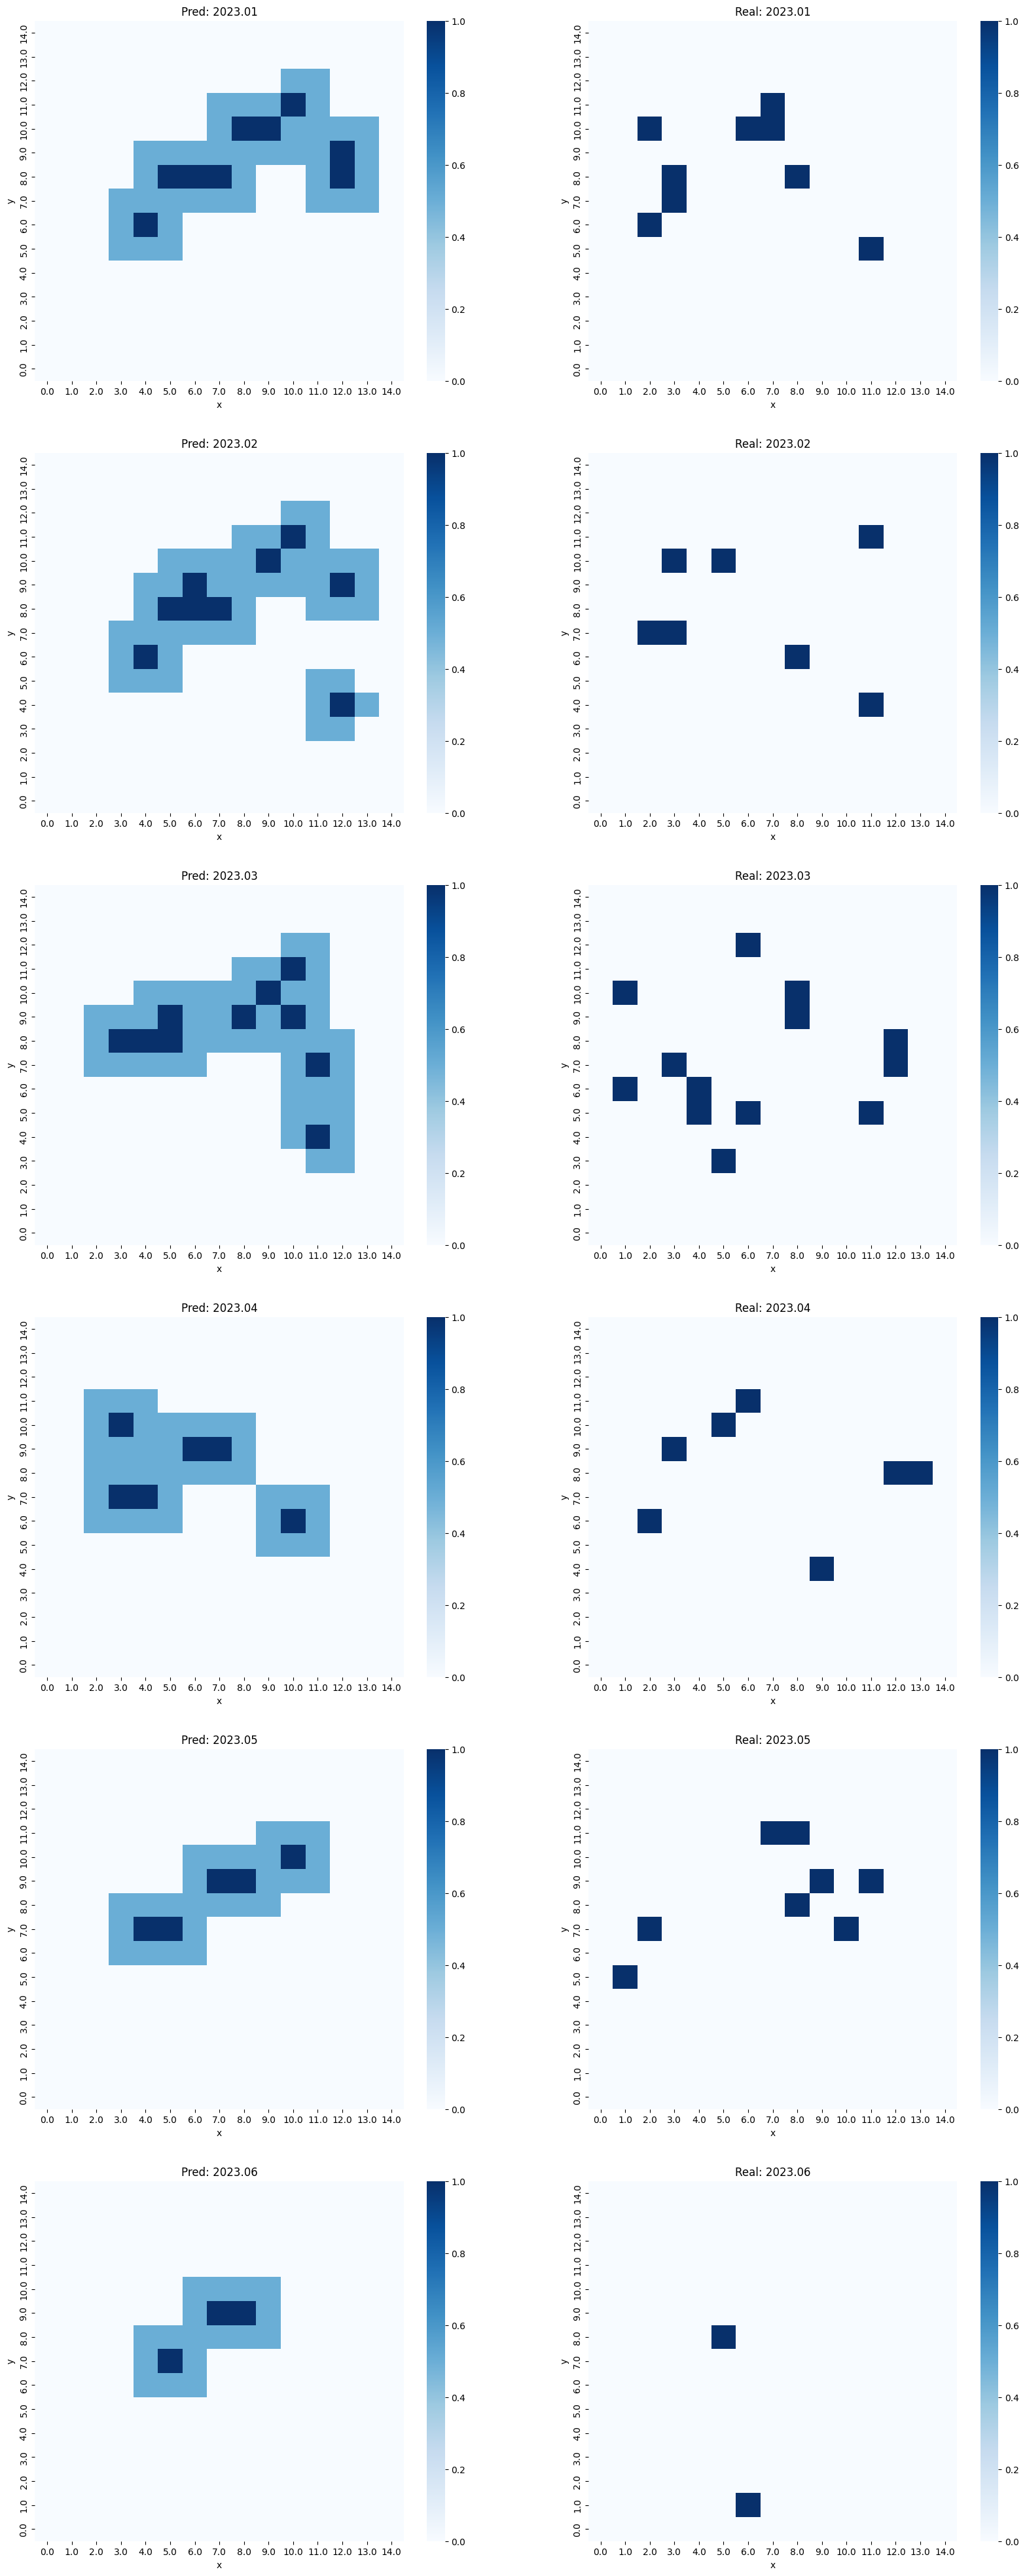

In [77]:
# 실제 화재 좌표와 예측 화재 좌표간의 비교
fig, ax = plt.subplots(ncols=2, nrows=6, figsize=(20, 50))

sns.heatmap(pred_heatmap_1, cmap='Blues', ax=ax[0][0])
sns.heatmap(real_heatmap_1, cmap='Blues', ax=ax[0][1])
sns.heatmap(pred_heatmap_2, cmap='Blues', ax=ax[1][0])
sns.heatmap(real_heatmap_2, cmap='Blues', ax=ax[1][1])
sns.heatmap(pred_heatmap_3, cmap='Blues', ax=ax[2][0])
sns.heatmap(real_heatmap_3, cmap='Blues', ax=ax[2][1])
sns.heatmap(pred_heatmap_4, cmap='Blues', ax=ax[3][0])
sns.heatmap(real_heatmap_4, cmap='Blues', ax=ax[3][1])
sns.heatmap(pred_heatmap_5, cmap='Blues', ax=ax[4][0])
sns.heatmap(real_heatmap_5, cmap='Blues', ax=ax[4][1])
sns.heatmap(pred_heatmap_6, cmap='Blues', ax=ax[5][0])
sns.heatmap(real_heatmap_6, cmap='Blues', ax=ax[5][1])

ax[0][0].set_title('Pred: 2023.01')
ax[0][1].set_title('Real: 2023.01')
ax[1][0].set_title('Pred: 2023.02')
ax[1][1].set_title('Real: 2023.02')
ax[2][0].set_title('Pred: 2023.03')
ax[2][1].set_title('Real: 2023.03')
ax[3][0].set_title('Pred: 2023.04')
ax[3][1].set_title('Real: 2023.04')
ax[4][0].set_title('Pred: 2023.05')
ax[4][1].set_title('Real: 2023.05')
ax[5][0].set_title('Pred: 2023.06')
ax[5][1].set_title('Real: 2023.06')

In [99]:
real_fires = df_real[df_real['fire'] == 1].values.tolist()
pred_fires = df_pred[df_pred['fire'] == 1].values.tolist()

In [105]:
# 예측한 좌표 그 자체에서의 정확도
correct = 0

for fire in real_fires:
    if fire in pred_fires: 
        correct += 1

print('예측한 곳에서 정확히 불이 난 횟수:', correct)
print('정확도:', correct / len(pred_fires))

예측한 곳에서 정확히 불이 난 횟수: 1
정확도: 0.014705882352941176


In [104]:
# 예측한 좌표 주변에서의 정확도 (주변 8개의 좌표를 포함한다고 할 때)
correct = 0

for fire in real_fires:
    if fire in pred_fires: 
        correct += 1
    elif [fire[0], fire[1]+1, fire[2], fire[3]] in pred_fires:
        correct += 1
    elif [fire[0], fire[1]-1, fire[2], fire[3]] in pred_fires:
        correct += 1
    elif [fire[0], fire[1], fire[2]+1, fire[3]] in pred_fires:
        correct += 1
    elif [fire[0], fire[1], fire[2]-1, fire[3]] in pred_fires:
        correct += 1
    elif [fire[0], fire[1]+1, fire[2]+1, fire[3]] in pred_fires:
        correct += 1
    elif [fire[0], fire[1]+1, fire[2]-1, fire[3]] in pred_fires:
        correct += 1
    elif [fire[0], fire[1]-1, fire[2]+1, fire[3]] in pred_fires:
        correct += 1
    elif [fire[0], fire[1]-1, fire[2]-1, fire[3]] in pred_fires:
        correct += 1

print('예측한 곳 주변좌표에서 불이 난 횟수:', correct)
print('정확도:', correct / len(pred_fires))

예측한 곳 주변좌표에서 불이 난 횟수: 21
정확도: 0.3088235294117647
